## Data Preparation

### Imports

Packages that need to be imported:

In [1]:
import pandas as pd
import json
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

### Read dataframe

Read json file with words and the list of videos:

In [2]:
url = "https://raw.githubusercontent.com/dxli94/WLASL/master/start_kit/WLASL_v0.3.json"
df = pd.read_json(url)
df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [3]:
#Export a list of words in csv
#df["gloss"].to_csv("list_words.csv")

### Filter df only selected words

Filter the json file with words that will be used to train our model. This file will be used later to download the videos.

In [4]:
list_selected_words = ["headache", "cough", "sore throat", "blood", "pregnant", "diabetes", 
                       "stomach","pain", "allergy", "cold", "bone","diarrhea", "heart", "heart attack", 
                       "cochlear implant", "vomit", "depressed", "hurt", "infection", "tired", "thank you"]

df = df[df['gloss'].isin(list_selected_words)]
df.head()

,gloss,instances
117,headache,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
147,cold,"[{'bbox': [129, 16, 476, 370], 'fps': 25, 'fra..."
175,tired,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
269,cough,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
287,heart,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [5]:
print(f"Df shape: {df.shape}")

Df shape: (21, 2)


### Export pandas df to json file

In [6]:
#new_json = df.to_json("WLASL_v0.3.json", orient='records')

### Explore instances

Create a dataframe with video_ids and the corresponding word. Notice that in this step we are using the json file exported in the previous step, which contains information about only 21 words.

In [6]:
content = json.load(open("../scripts/WLASL_v0.3.json"))

id_videos = []
for entry in content:
    word = entry["gloss"]
    instances = entry['instances']

    for inst in instances:
        video_id = inst['video_id']
        id_videos.append([word, video_id])

In [7]:
id_list = pd.DataFrame(id_videos, columns=["word", "video_id"])
id_list.head()

,word,video_id
0,headache,26832
1,headache,26835
2,headache,26836
3,headache,26837
4,headache,26838


Because of problems during download, we were not able to download all video_ids. To count the real number of videos that we have available, we need to check if they are in our folder.

In [8]:
ids_in_folder = []

for video_id in id_list.video_id:
    if os.path.exists(f'../raw_data/{video_id}.mp4'):
        ids_in_folder.append(video_id)

print(f"Number os videos: {len(ids_in_folder)}")

Number os videos: 154


Filter dataframe to only videos available in our folder:

In [9]:
id_list = id_list[id_list['video_id'].isin(ids_in_folder)]
print(f"Shape new df: {id_list.shape}")

Shape new df: (154, 2)


#### Count videos per symptoms
Check how many videos we have, by symptom, to train our model.

In [10]:
aux_list = id_list.groupby("word").count().reset_index()
aux_list.sort_values("video_id")

,word,video_id
2,bone,4
1,blood,5
14,pain,6
18,thank you,6
13,infection,6
6,depressed,6
7,diabetes,6
15,pregnant,6
11,heart attack,6
0,allergy,7


## Setup Preparation

### Setup Folder

In [12]:
# # Path for exported data, numpy arrays
# DATA_PATH = os.path.join('../MP_Data') 

# # Videos are going to be 70 frames in length
# sequence_length = 70 #wont be used anymore

In [24]:
# # ----------------------------------------------------
# # Loop to create folders for each action to be trained
# # and n_folder depending on the number of videos
# # ----------------------------------------------------

# for word in range(0, len(aux_list.word)):   # modificar range depois dos testes (0, len..)
    
#     # Identify how many videos per action
#     n_folders = aux_list.iloc[word, 1]
    
#     # Create folders
#     for n in range(n_folders):
#         try:
#             folder = os.path.join(DATA_PATH, aux_list.iloc[word, 0], str(n))
#             os.makedirs(folder)
#         except:
#             pass

### Functions for data detection

In [11]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [12]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [13]:
mediapipe_detection

<function __main__.mediapipe_detection(image, model)>

In [14]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [15]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [16]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## Length Histogram

### To check lenght of videos

In [17]:
# Function to extract video id for selected word - Giovanna 
def videos_word(word):
  
    id_list_novo = id_list[id_list['word'] == word]
    lista_videos = [video_id for video_id in id_list_novo.video_id]
    
    return lista_videos

In [18]:
# Function to return duration and framecount for each video
def with_opencv(filename):
    import cv2
    video = cv2.VideoCapture(filename)

    duration = video.get(cv2.CAP_PROP_POS_MSEC)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

    return duration, frame_count



# Get id_videos from function video_words and return lenght
n_frames = []
teste = []

for word in aux_list["word"]:
    for video_id in videos_word(word):
        video = f'../raw_data/{video_id}.mp4'
        frame_count = with_opencv(video)[1]
        n_frames.append(frame_count)
        teste.append([word, video_id, frame_count])
        
frames_words = pd.DataFrame(teste, columns=["action", "video_id", "frames"])
frames_words

,action,video_id,frames
0,allergy,01962,54.0
1,allergy,01955,119.0
2,allergy,01965,106.0
3,allergy,01956,40.0
4,allergy,01957,108.0
...,...,...,...
149,vomit,61987,30.0
150,vomit,61990,98.0
151,vomit,61978,115.0
152,vomit,61979,84.0


In [19]:
# words = []


df_words = frames_words[frames_words['action'] == 'cough']
df_words


,action,video_id,frames
37,cough,13473,48.0
38,cough,65411,66.0
39,cough,13478,77.0
40,cough,13468,87.0
41,cough,13469,60.0
42,cough,13470,82.0
43,cough,13471,40.0
44,cough,13472,49.0


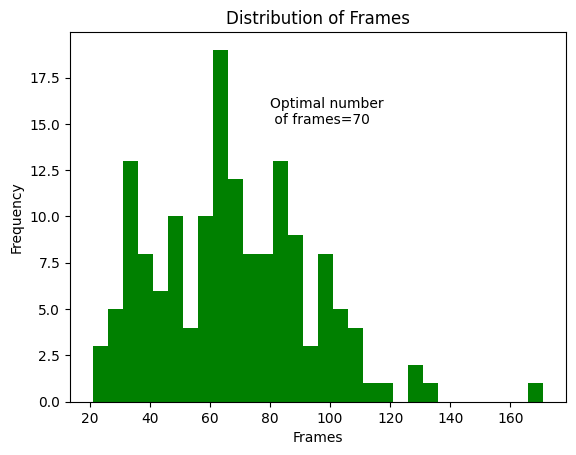

In [20]:
# Plot distribution frames 
plt.title("Distribution of Frames")
plt.xlabel('Frames')
plt.ylabel('Frequency')
plt.hist(pd.DataFrame(n_frames), bins=30, color="g", stacked=True);
plt.text(80, 15, f'Optimal number \n of frames=70');

In [21]:
# Function to retrieve words, video, frames

def words_video(word):
    w = frames_words[frames_words['action'] == word].reset_index()
    return w


In [22]:
words_video("cochlear implant")

,index,action,video_id,frames
0,16,cochlear implant,65373,57.0
1,17,cochlear implant,11498,98.0
2,18,cochlear implant,11499,33.0
3,19,cochlear implant,11500,32.0
4,20,cochlear implant,11501,128.0
5,21,cochlear implant,11502,65.0
6,22,cochlear implant,11503,33.0
7,23,cochlear implant,11504,50.0


## Data Points - New

#### Model Plan A - with loop

In [20]:
# # ---------------------------------------------------
# # Function to extract data points
# # Action = word
# # Folder = /word/number_folder
# # Video_id = name of the video
# # ---------------------------------------------------


# def extract_datapoints(action, folder, video_id, frames):
    
#     data_path = os.path.join('../MP_Data')
    
#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

#         for frame_num in range(frames):

#                     # Read feed
#                     ret, frame = cap.read()

#                     # Make detections
#                     try:
#                         image, results = mediapipe_detection(frame, holistic)
#                         print(results)

#                         # Draw landmarks and text
#                         draw_styled_landmarks(image, results)
#                         cv2.putText(image, 'Frames for {} video {}'.format(action, folder), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 0, 255), 1, cv2.LINE_AA)

#                         # Show to screen
#                         cv2.imshow('OpenCV Feed', image)
#                         cv2.waitKey(500)

#                         # Export keypoints
#                         keypoints = extract_keypoints(results)
#                         npy_path = os.path.join(data_path, action, folder, str(frame_num))
#                         np.save(npy_path, keypoints)

#                         # Break gracefully
#                         if cv2.waitKey(10) & 0xFF == ord('q'):
#                             break
#                     except:
#                         pass

In [28]:
# # ---------------------------------------------------
# # Loop to extract data points using function
# # ---------------------------------------------------

# selected_word = ["pregnant"]

# for word in selected_word:
            
#     # Filter the dataframe
#     df_temp = frames_words[frames_words["action"] == word] 

#     # Get information for each action
#     for word in range(0, len(df_temp.action)):

#         action = df_temp.iloc[word, 0]
#         cap = cv2.VideoCapture(f"../raw_data/{df_temp.iloc[word, 1]}.mp4")
#         sequence_folder = word
#         frames = [int(df_temp.iloc[word, 2]) if int(df_temp.iloc[word, 2]) < 70 else 70][0]

#         # Call the function to extract data points
#         extract_datapoints(action, str(sequence_folder), cap, frames)

#### Model  - Plan B 

In [28]:
# #GIO'S METHOD

# # Set mediapipe model 

# cap = cv2.VideoCapture(f'../raw_data/40807.mp4') # Video exemplo muito curto - 50 frames dá erro!


# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     data_path = os.path.join('../MP_Data')
    
#     for frame_num in range(22):

#                 # Read feed
            
#                 ret, frame = cap.read()

#                 # Make detections
#                 image, results = mediapipe_detection(frame, holistic)
#                 print(results)
                
#                 # Draw landmarks
#                 draw_styled_landmarks(image, results)
                
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format("teste", 1), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 0, 255), 1, cv2.LINE_AA)
                
#                  # Show to screen
#                 cv2.imshow('OpenCV Feed', image)
#                 cv2.waitKey(500)
                
                
#                 # Export keypoints
#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(data_path, "teste", str(1), str(frame_num))
#                 np.save(npy_path, keypoints)

#                 # Break gracefully
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break

#### Model - Plan C

In [24]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('../MP_Data_Web') 

# Actions that we try to detect
actions = np.array(['headache', 'tired', 'sore throat', 'infection'])

# Thirty videos worth of data
no_sequences = 60

# Videos are going to be 30 frames in length
sequence_length = 30

In [25]:
# #Create Folders for Keypoint Collection

# for action in actions: 
#     for sequence in range(no_sequences):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except:
#             pass

In [26]:
pwd

'/Users/pr/code/pariosur/sign-language-translator/notebooks'

In [29]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     # NEW LOOP
#     # Loop through actions
#     for action in actions:
#         # Loop through sequences aka videos
#         for sequence in range(no_sequences):
#             # Loop through video length aka sequence length
#             for frame_num in range(sequence_length):

#                 # Read feed
#                 ret, frame = cap.read()

#                 # Make detections
#                 image, results = mediapipe_detection(frame, holistic)
# #                 print(results)

#                 # Draw landmarks
#                 draw_styled_landmarks(image, results)
                
#                 # NEW Apply wait logic
#                 if frame_num == 0: 
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
#                     cv2.waitKey(2000)
#                 else: 
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
                
#                 # NEW Export keypoints
#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
#                 np.save(npy_path, keypoints)

#                 # Break gracefully
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break
                    


In [30]:
cap.release()
cv2.destroyAllWindows()

### Np array comparison

In [28]:
# Sem loop
for i in range(0, 25):
    print(np.load(f"../MP_Data_Web/headache/4/{i}.npy"))

[ 0.52384019  0.2467172  -0.43165499 ...  0.44315311  0.25633395
 -0.01921165]
[ 0.52530563  0.23926795 -0.43805951 ...  0.4279722   0.21914801
 -0.01720683]
[ 0.52567011  0.23632923 -0.45100373 ...  0.43328556  0.22517821
 -0.02259512]
[ 0.52619517  0.23519798 -0.5240587  ...  0.43446568  0.2267099
 -0.02076488]
[ 0.52699661  0.23111705 -0.50281394 ...  0.43827814  0.22534126
 -0.01849702]
[ 0.52711165  0.2308279  -0.43136126 ...  0.43793258  0.23344997
 -0.02090538]
[ 0.52689445  0.22958247 -0.53921157 ...  0.43472344  0.23062019
 -0.02215356]
[ 0.5268991   0.22964486 -0.53816634 ...  0.43550506  0.23661925
 -0.02315896]
[ 0.52701187  0.22991677 -0.45526004 ...  0.44098198  0.24370462
 -0.02415671]
[ 0.52798671  0.23003578 -0.42877442 ...  0.44247404  0.22875839
 -0.01702341]
[ 0.53065276  0.23021777 -0.43271437 ...  0.43286499  0.21307099
 -0.01155319]
[ 0.5322898   0.23030511 -0.4585723  ...  0.4303613   0.20853649
 -0.01098728]
[ 0.53599519  0.2303475  -0.45936626 ...  0.43392685 

In [28]:
# # Com loop
# for i in range(5, 15):
#     print(np.load(f"../MP_Data/teste/1/{i}.npy"))

## Extract Data Points - Old

### Extract data points from videos

In [29]:
# # ---------------------------------------------------
# #  Function to extract data points from videos
# #  Action = words
# #  Video_id = name of the video
# #  Sequence = folder in which it will be placed
# # ---------------------------------------------------

# def extract_data_points(action, video_id, folder):
    
#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

#         for frame_num in range(sequence_length):
            
#             sequence = 1

#             # Read feed
#             cap = cv2.VideoCapture(f'../raw_data/{video_id}.mp4')
#             ret, frame = cap.read()

#             # Make detections
#             image, results = mediapipe_detection(frame, holistic)
#             print(results)

#             # Draw landmarks
#             draw_styled_landmarks(image, results)

#             # Apply wait logic
#             if frame_num == 0: 
#                 cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

#                 # Show to screen
#                 cv2.imshow('OpenCV Feed', image)
#                 cv2.waitKey(2000)
#             else: 
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                 # Show to screen
#                 cv2.imshow('OpenCV Feed', image)

#             # Export keypoints
#             keypoints = extract_keypoints(results)
#             npy_path = os.path.join(DATA_PATH, action, str(folder), str(frame_num))
#             np.save(npy_path, keypoints)

#             # Break gracefully
#             if cv2.waitKey(10) & 0xFF == ord('q'):
#                 break

In [30]:
# # ---------------------------------------------------
# # Loop to extract data points for each word and video
# # and save it in the correct folder
# # ---------------------------------------------------

# for word in id_list.word.unique():
    
#     if word == "tired": #apagar depois dos testes, filtra apenas 1 palavra
        
#         # Filter the dataframe
#         df_temp = id_list[id_list["word"] == word] 

#         # Get information for each action
#         for word in range(0, len(df_temp.word)):

#             action = df_temp.iloc[word, 0]
#             video_id = df_temp.iloc[word, 1]
#             sequence = word

#             # Call the function to extract data points
#             extract_data_points(action, video_id, sequence)

### Extract data points from webcam

In [24]:
# # ---------------------------------------------------
# # Function to extract data points from webcam to
# # complement actions with less than x videos. This
# # function also creates additional folders

# # Action = list of words
# # no_sequence = number of additional videos to create
# # ---------------------------------------------------

# def extract_data_points_webcam(actions, no_sequences):
    
#     # Extract video from webcam
#     cap = cv2.VideoCapture(0)
    
#     # Set mediapipe model 
#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

#         # Loop through actions
#         for action in actions:
            
#             #Identify number of folders for this action
#             start_folder = int(max(os.listdir(f"../MP_Data/{action}")))+1
            
#             # Loop through sequences aka videos
#             for sequence in range(start_folder, start_folder+no_sequences):
                
#                 # Create folder before export
#                 os.makedirs(os.path.join(DATA_PATH, action, str(sequence))) 
                
#                 # Loop through video length aka sequence length
#                 for frame_num in range(sequence_length):

#                     # Read feed
#                     ret, frame = cap.read()

#                     # Make detections
#                     image, results = mediapipe_detection(frame, holistic)

#                     # Draw landmarks
#                     draw_styled_landmarks(image, results)

#                     # Apply wait logic
#                     if frame_num == 0: 
#                         cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                         cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                         # Show to screen
#                         cv2.imshow('OpenCV Feed', image)
#                         cv2.waitKey(500)
#                     else: 
#                         cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                         # Show to screen
#                         cv2.imshow('OpenCV Feed', image)

#                     # Export keypoints
#                     keypoints = extract_keypoints(results)                    
#                     npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
#                     np.save(npy_path, keypoints)

#                     # Break gracefully
#                     if cv2.waitKey(10) & 0xFF == ord('q'):
#                         break

#         cap.release()
#         cv2.destroyAllWindows()
                    

In [41]:
# # ---------------------------------------------------
# # Create additional videos for selected words
# # ---------------------------------------------------

# list_words = ['vomit']
# extract_data_points_webcam(list_words, 5)


## Data Augmentation

In [2]:
!pip install git+https://github.com/okankop/vidaug

  Cloning https://github.com/okankop/vidaug to /private/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/pip-req-build-9fevg1xn
  Running command git clone -q https://github.com/okankop/vidaug /private/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/pip-req-build-9fevg1xn
You should consider upgrading via the '/Users/pr/.pyenv/versions/3.8.12/envs/sign-language-translator/bin/python -m pip install --upgrade pip' command.


In [3]:
from vidaug import augmentors as va


ModuleNotFoundError: No module named 'vidaug'

## Preprocess Data and Create Labels and Features

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [30]:
label_map = {label:num for num, label in enumerate(actions)}


In [31]:
label_map

{'headache': 0, 'tired': 1, 'sore throat': 2, 'infection': 3}

In [89]:
# no_videos = 3
# seq_lenght_test = 30

In [32]:
np.load('/Users/pr/code/pariosur/sign-language-translator/MP_Data_Web/tired/0/3.npy')

array([ 0.54174018,  0.28855076, -0.60200274, ...,  0.        ,
        0.        ,  0.        ])

In [33]:
np.load('/Users/pr/code/pariosur/sign-language-translator/MP_Data_Web/tired/0/4.npy')

array([ 0.52520257,  0.23057598, -0.50659865, ...,  0.4024156 ,
        0.78690308, -0.00830284])

In [34]:
aux_list.video_id

0      7
1      5
2      4
3      8
4     13
5      8
6      6
7      6
8      7
9     10
10    10
11     6
12     7
13     6
14     6
15     6
16     7
17     8
18     6
19     8
20    10
Name: video_id, dtype: int64

In [35]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [36]:
np.array(sequences).shape


(240, 30, 1662)

In [37]:
np.array(labels).shape


(240,)

In [38]:
X = np.array(sequences)
X.shape

(240, 30, 1662)

In [39]:
y = to_categorical(labels).astype(int)
y


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0,

BREAK

In [40]:
np.array(sequences).shape

(240, 30, 1662)

In [41]:
np.array(labels).shape

(240,)

In [42]:
X = np.array(sequences)
X.shape

(240, 30, 1662)

In [43]:
y = to_categorical(labels).astype(int)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)


In [45]:
y_test.shape


(12, 4)

## Build and Train LSTM Neural Network

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
log_dir = os.path.join('Logs_Web')
tb_callback = TensorBoard(log_dir=log_dir)

2022-09-06 09:58:59.062225: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-06 09:58:59.062305: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-06 09:58:59.069681: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Model 1

In [48]:
model = Sequential()
model.add(GRU(32, return_sequences=False, activation='relu', input_shape=(30,1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

2022-09-06 09:59:00.773898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
actions.shape[0]

4

In [50]:
res = [.7, 0.9, 0.95, 0.1, 0.1, 0.1]
res

[0.7, 0.9, 0.95, 0.1, 0.1, 0.1]

In [51]:
actions[np.argmax(res)]


'sore throat'

In [52]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [53]:
es = EarlyStopping(patience=500, restore_best_weights=True)
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback,es], validation_split = 0.3, batch_size = 16)


2022-09-06 09:59:14.060764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000
 9/10 [==========================>...] - ETA: 0s - loss: 1.7712 - categorical_accuracy: 0.2708

2022-09-06 09:59:15.014587: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-06 09:59:15.014606: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-06 09:59:15.031538: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-06 09:59:15.055906: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-09-06 09:59:15.095458: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs_Web/train/plugins/profile/2022_09_06_09_59_15
2022-09-06 09:59:15.105563: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs_Web/train/plugins/profile/2022_09_06_09_59_15/Pablos-MacBook-Pro.local.trace.json.gz
2022-09-06 09:59:15.117530: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs_Web/train/plugins/profile/2022_09_06_09_59_15
2022-09

10/10 [==============================] - 1s 43ms/step - loss: 1.7153 - categorical_accuracy: 0.2956 - val_loss: 1.7173 - val_categorical_accuracy: 0.1304
Epoch 2/2000
10/10 [==============================] - 0s 12ms/step - loss: 1.3476 - categorical_accuracy: 0.3396 - val_loss: 1.3840 - val_categorical_accuracy: 0.1304
Epoch 3/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.3211 - categorical_accuracy: 0.3774 - val_loss: 1.3312 - val_categorical_accuracy: 0.4058
Epoch 4/2000
10/10 [==============================] - 0s 13ms/step - loss: 1.2800 - categorical_accuracy: 0.4214 - val_loss: 1.3210 - val_categorical_accuracy: 0.1739
Epoch 5/2000
10/10 [==============================] - 0s 15ms/step - loss: 1.2235 - categorical_accuracy: 0.5094 - val_loss: 1.3698 - val_categorical_accuracy: 0.1594
Epoch 6/2000
10/10 [==============================] - 0s 17ms/step - loss: 1.1229 - categorical_accuracy: 0.4969 - val_loss: 1.2410 - val_categorical_accuracy: 0.1739
Epoch 7/200

Epoch 50/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0463 - categorical_accuracy: 0.9874 - val_loss: 0.4678 - val_categorical_accuracy: 0.8841
Epoch 51/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.1349 - categorical_accuracy: 0.9497 - val_loss: 0.5387 - val_categorical_accuracy: 0.8261
Epoch 52/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.1254 - categorical_accuracy: 0.9686 - val_loss: 0.0879 - val_categorical_accuracy: 0.9710
Epoch 53/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0875 - categorical_accuracy: 0.9686 - val_loss: 0.0307 - val_categorical_accuracy: 1.0000
Epoch 54/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.2303 - categorical_accuracy: 0.9182 - val_loss: 0.0425 - val_categorical_accuracy: 1.0000
Epoch 55/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0491 - categorical_accuracy: 0.9874 - val_loss: 0.0216 - val_categorical_accuracy:

Epoch 99/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0099 - categorical_accuracy: 1.0000 - val_loss: 0.0130 - val_categorical_accuracy: 1.0000
Epoch 100/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0062 - categorical_accuracy: 1.0000 - val_loss: 0.0100 - val_categorical_accuracy: 1.0000
Epoch 101/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0044 - categorical_accuracy: 1.0000 - val_loss: 0.0125 - val_categorical_accuracy: 1.0000
Epoch 102/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0070 - categorical_accuracy: 1.0000 - val_loss: 0.0084 - val_categorical_accuracy: 1.0000
Epoch 103/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0034 - categorical_accuracy: 1.0000 - val_loss: 0.0251 - val_categorical_accuracy: 1.0000
Epoch 104/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.7031 - categorical_accuracy: 0.8679 - val_loss: 0.0142 - val_categorical_accu

10/10 [==============================] - 0s 11ms/step - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 0.0046 - val_categorical_accuracy: 1.0000
Epoch 148/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.0029 - val_categorical_accuracy: 1.0000
Epoch 149/2000
10/10 [==============================] - 0s 11ms/step - loss: 9.9319e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0036 - val_categorical_accuracy: 1.0000
Epoch 150/2000
10/10 [==============================] - 0s 11ms/step - loss: 7.9623e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0089 - val_categorical_accuracy: 1.0000
Epoch 151/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.4279 - categorical_accuracy: 0.9434 - val_loss: 0.0174 - val_categorical_accuracy: 1.0000
Epoch 152/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0740 - categorical_accuracy: 0.9686 - val_loss: 0.0402 - val_categorical_accuracy: 

Epoch 195/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0110 - categorical_accuracy: 1.0000 - val_loss: 0.0118 - val_categorical_accuracy: 1.0000
Epoch 196/2000
10/10 [==============================] - 0s 11ms/step - loss: 9.0759e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0064 - val_categorical_accuracy: 1.0000
Epoch 197/2000
10/10 [==============================] - 0s 10ms/step - loss: 3.8846e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0054 - val_categorical_accuracy: 1.0000
Epoch 198/2000
10/10 [==============================] - 0s 11ms/step - loss: 3.1949e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0044 - val_categorical_accuracy: 1.0000
Epoch 199/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.5168e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0035 - val_categorical_accuracy: 1.0000
Epoch 200/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.0985e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0028 -

Epoch 242/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.9120e-06 - categorical_accuracy: 1.0000 - val_loss: 1.9951e-04 - val_categorical_accuracy: 1.0000
Epoch 243/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.0903e-06 - categorical_accuracy: 1.0000 - val_loss: 0.0011 - val_categorical_accuracy: 1.0000
Epoch 244/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.5055e-06 - categorical_accuracy: 1.0000 - val_loss: 2.0911e-04 - val_categorical_accuracy: 1.0000
Epoch 245/2000
10/10 [==============================] - 0s 11ms/step - loss: 9.5517e-07 - categorical_accuracy: 1.0000 - val_loss: 4.4405e-04 - val_categorical_accuracy: 1.0000
Epoch 246/2000
10/10 [==============================] - 0s 12ms/step - loss: 7.1975e-07 - categorical_accuracy: 1.0000 - val_loss: 5.6448e-05 - val_categorical_accuracy: 1.0000
Epoch 247/2000
10/10 [==============================] - 0s 11ms/step - loss: 6.8676e-07 - categorical_accuracy: 1.0000 

10/10 [==============================] - 0s 12ms/step - loss: 7.7550e-05 - categorical_accuracy: 1.0000 - val_loss: 5.3200e-04 - val_categorical_accuracy: 1.0000
Epoch 290/2000
10/10 [==============================] - 0s 11ms/step - loss: 5.0822e-05 - categorical_accuracy: 1.0000 - val_loss: 5.5018e-04 - val_categorical_accuracy: 1.0000
Epoch 291/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.8089e-05 - categorical_accuracy: 1.0000 - val_loss: 5.5197e-04 - val_categorical_accuracy: 1.0000
Epoch 292/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.6629e-05 - categorical_accuracy: 1.0000 - val_loss: 5.7278e-04 - val_categorical_accuracy: 1.0000
Epoch 293/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.1570e-05 - categorical_accuracy: 1.0000 - val_loss: 5.5145e-04 - val_categorical_accuracy: 1.0000
Epoch 294/2000
10/10 [==============================] - 0s 12ms/step - loss: 8.6447e-06 - categorical_accuracy: 1.0000 - val_loss:

10/10 [==============================] - 0s 11ms/step - loss: 3.7337e-07 - categorical_accuracy: 1.0000 - val_loss: 1.7951e-04 - val_categorical_accuracy: 1.0000
Epoch 337/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.1143e-07 - categorical_accuracy: 1.0000 - val_loss: 6.7863e-04 - val_categorical_accuracy: 1.0000
Epoch 338/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.0796e-07 - categorical_accuracy: 1.0000 - val_loss: 3.7030e-04 - val_categorical_accuracy: 1.0000
Epoch 339/2000
10/10 [==============================] - 0s 11ms/step - loss: 8.2472e-08 - categorical_accuracy: 1.0000 - val_loss: 2.0102e-04 - val_categorical_accuracy: 1.0000
Epoch 340/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.1313 - categorical_accuracy: 0.9308 - val_loss: 0.2114 - val_categorical_accuracy: 0.9565
Epoch 341/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0039 - categorical_accuracy: 1.0000 - val_loss: 0.0228 - va

10/10 [==============================] - 0s 12ms/step - loss: 1.6165e-05 - categorical_accuracy: 1.0000 - val_loss: 3.9498e-04 - val_categorical_accuracy: 1.0000
Epoch 384/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.4677e-05 - categorical_accuracy: 1.0000 - val_loss: 1.0261e-04 - val_categorical_accuracy: 1.0000
Epoch 385/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.0206e-05 - categorical_accuracy: 1.0000 - val_loss: 1.8097e-04 - val_categorical_accuracy: 1.0000
Epoch 386/2000
10/10 [==============================] - 0s 10ms/step - loss: 3.5147e-06 - categorical_accuracy: 1.0000 - val_loss: 2.2552e-04 - val_categorical_accuracy: 1.0000
Epoch 387/2000
10/10 [==============================] - 0s 10ms/step - loss: 2.3032e-06 - categorical_accuracy: 1.0000 - val_loss: 3.1126e-04 - val_categorical_accuracy: 1.0000
Epoch 388/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.5332e-06 - categorical_accuracy: 1.0000 - val_loss:

10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 1.6597e-05 - val_categorical_accuracy: 1.0000
Epoch 430/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 2.0366e-05 - val_categorical_accuracy: 1.0000
Epoch 431/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 2.0651e-05 - val_categorical_accuracy: 1.0000
Epoch 432/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 2.5012e-05 - val_categorical_accuracy: 1.0000
Epoch 433/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 2.6629e-05 - val_categorical_accuracy: 1.0000
Epoch 434/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss:

10/10 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 5.5842e-04 - val_categorical_accuracy: 1.0000
Epoch 476/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 5.6912e-04 - val_categorical_accuracy: 1.0000
Epoch 477/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 5.1599e-04 - val_categorical_accuracy: 1.0000
Epoch 478/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 5.4516e-04 - val_categorical_accuracy: 1.0000
Epoch 479/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 5.2592e-04 - val_categorical_accuracy: 1.0000
Epoch 480/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss:

10/10 [==============================] - 0s 11ms/step - loss: 7.4974e-10 - categorical_accuracy: 1.0000 - val_loss: 1.6067e-07 - val_categorical_accuracy: 1.0000
Epoch 522/2000
10/10 [==============================] - 0s 12ms/step - loss: 2.2492e-09 - categorical_accuracy: 1.0000 - val_loss: 2.2287e-07 - val_categorical_accuracy: 1.0000
Epoch 523/2000
10/10 [==============================] - 0s 12ms/step - loss: 2.9990e-09 - categorical_accuracy: 1.0000 - val_loss: 2.1078e-07 - val_categorical_accuracy: 1.0000
Epoch 524/2000
10/10 [==============================] - 0s 11ms/step - loss: 7.4974e-10 - categorical_accuracy: 1.0000 - val_loss: 1.5549e-07 - val_categorical_accuracy: 1.0000
Epoch 525/2000
10/10 [==============================] - 0s 12ms/step - loss: 1.4995e-09 - categorical_accuracy: 1.0000 - val_loss: 1.1403e-07 - val_categorical_accuracy: 1.0000
Epoch 526/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.4995e-09 - categorical_accuracy: 1.0000 - val_loss:

Epoch 568/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.5460e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0018 - val_categorical_accuracy: 1.0000
Epoch 569/2000
10/10 [==============================] - 0s 10ms/step - loss: 1.0980e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0020 - val_categorical_accuracy: 1.0000
Epoch 570/2000
10/10 [==============================] - 0s 11ms/step - loss: 7.5263e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0024 - val_categorical_accuracy: 1.0000
Epoch 571/2000
10/10 [==============================] - 0s 11ms/step - loss: 5.5054e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0013 - val_categorical_accuracy: 1.0000
Epoch 572/2000
10/10 [==============================] - 0s 11ms/step - loss: 3.9644e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0019 - val_categorical_accuracy: 1.0000
Epoch 573/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.6362e-05 - categorical_accuracy: 1.0000 - val_loss: 9.42

10/10 [==============================] - 0s 12ms/step - loss: 2.5693e-06 - categorical_accuracy: 1.0000 - val_loss: 0.0012 - val_categorical_accuracy: 1.0000
Epoch 616/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.0138e-06 - categorical_accuracy: 1.0000 - val_loss: 0.0015 - val_categorical_accuracy: 1.0000
Epoch 617/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.1156e-06 - categorical_accuracy: 1.0000 - val_loss: 0.0037 - val_categorical_accuracy: 1.0000
Epoch 618/2000
10/10 [==============================] - 0s 11ms/step - loss: 6.9951e-07 - categorical_accuracy: 1.0000 - val_loss: 0.0071 - val_categorical_accuracy: 1.0000
Epoch 619/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.0576 - categorical_accuracy: 0.9308 - val_loss: 0.5902 - val_categorical_accuracy: 0.9275
Epoch 620/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.1612 - categorical_accuracy: 0.9748 - val_loss: 1.1932e-04 - val_categorica

Epoch 662/2000
10/10 [==============================] - 0s 12ms/step - loss: 8.0972e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0014 - val_categorical_accuracy: 1.0000
Epoch 663/2000
10/10 [==============================] - 0s 20ms/step - loss: 4.6484e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0019 - val_categorical_accuracy: 1.0000
Epoch 664/2000
10/10 [==============================] - 0s 12ms/step - loss: 2.9240e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0020 - val_categorical_accuracy: 1.0000
Epoch 665/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.7244e-08 - categorical_accuracy: 1.0000 - val_loss: 9.0063e-04 - val_categorical_accuracy: 1.0000
Epoch 666/2000
10/10 [==============================] - 0s 11ms/step - loss: 1.1246e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0021 - val_categorical_accuracy: 1.0000
Epoch 667/2000
10/10 [==============================] - 0s 11ms/step - loss: 6.7477e-09 - categorical_accuracy: 1.0000 - val_loss: 

Epoch 709/2000
10/10 [==============================] - 0s 11ms/step - loss: 5.0308e-07 - categorical_accuracy: 1.0000 - val_loss: 2.2812e-04 - val_categorical_accuracy: 1.0000
Epoch 710/2000
10/10 [==============================] - 0s 13ms/step - loss: 3.5913e-07 - categorical_accuracy: 1.0000 - val_loss: 0.0138 - val_categorical_accuracy: 1.0000
Epoch 711/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.2922 - categorical_accuracy: 0.9686 - val_loss: 0.0150 - val_categorical_accuracy: 1.0000
Epoch 712/2000
10/10 [==============================] - 0s 11ms/step - loss: 5.8801e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0026 - val_categorical_accuracy: 1.0000
Epoch 713/2000
10/10 [==============================] - 0s 11ms/step - loss: 3.9625e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0024 - val_categorical_accuracy: 1.0000
Epoch 714/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.5215e-05 - categorical_accuracy: 1.0000 - val_loss: 0.00

Epoch 756/2000
10/10 [==============================] - 0s 12ms/step - loss: 3.1489e-08 - categorical_accuracy: 1.0000 - val_loss: 1.0888e-05 - val_categorical_accuracy: 1.0000
Epoch 757/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.3992e-08 - categorical_accuracy: 1.0000 - val_loss: 1.3873e-05 - val_categorical_accuracy: 1.0000
Epoch 758/2000
10/10 [==============================] - 0s 13ms/step - loss: 1.4995e-08 - categorical_accuracy: 1.0000 - val_loss: 2.8642e-05 - val_categorical_accuracy: 1.0000
Epoch 759/2000
10/10 [==============================] - 0s 12ms/step - loss: 1.1996e-08 - categorical_accuracy: 1.0000 - val_loss: 5.7669e-05 - val_categorical_accuracy: 1.0000
Epoch 760/2000
10/10 [==============================] - 0s 11ms/step - loss: 8.2472e-09 - categorical_accuracy: 1.0000 - val_loss: 1.0510e-04 - val_categorical_accuracy: 1.0000
Epoch 761/2000
10/10 [==============================] - 0s 12ms/step - loss: 5.9980e-09 - categorical_accuracy: 1.0

10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0899 - val_categorical_accuracy: 0.9710
Epoch 804/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0841 - val_categorical_accuracy: 0.9710
Epoch 805/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0981 - val_categorical_accuracy: 0.9710
Epoch 806/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0947 - val_categorical_accuracy: 0.9710
Epoch 807/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0954 - val_categorical_accuracy: 0.9710
Epoch 808/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0963 - val_catego

10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1111 - val_categorical_accuracy: 0.9710
Epoch 851/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1099 - val_categorical_accuracy: 0.9710
Epoch 852/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1103 - val_categorical_accuracy: 0.9710
Epoch 853/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1105 - val_categorical_accuracy: 0.9710
Epoch 854/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1088 - val_categorical_accuracy: 0.9710
Epoch 855/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1080 - val_catego

10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1050 - val_categorical_accuracy: 0.9710
Epoch 898/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1036 - val_categorical_accuracy: 0.9710
Epoch 899/2000
10/10 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1043 - val_categorical_accuracy: 0.9710
Epoch 900/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1051 - val_categorical_accuracy: 0.9710
Epoch 901/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1045 - val_categorical_accuracy: 0.9710
Epoch 902/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1058 - val_catego

10/10 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1371 - val_categorical_accuracy: 0.9710
Epoch 945/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1382 - val_categorical_accuracy: 0.9710
Epoch 946/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1393 - val_categorical_accuracy: 0.9710
Epoch 947/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1400 - val_categorical_accuracy: 0.9710
Epoch 948/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1404 - val_categorical_accuracy: 0.9710
Epoch 949/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.1425 - val_catego

10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.2049 - val_categorical_accuracy: 0.9710
Epoch 992/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.2061 - val_categorical_accuracy: 0.9710
Epoch 993/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.2076 - val_categorical_accuracy: 0.9710
Epoch 994/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.2096 - val_categorical_accuracy: 0.9710
Epoch 995/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.2107 - val_categorical_accuracy: 0.9710
Epoch 996/2000
10/10 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.2114 - val_catego

In [89]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                162816    
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 163,412
Trainable params: 163,412
Non-trainable params: 0
_________________________________________________________________


### Load Tensorboard

In [90]:

%load_ext tensorboard
%tensorboard --logdir '..notebooks/Logs/train'
%reload_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 28418), started 1:27:59 ago. (Use '!kill 28418' to kill it.)

## Make Predictions


In [91]:
res = model.predict(X_test)

In [92]:
actions[np.argmax(res[11])]


'headache'

In [93]:
actions[np.argmax(y_test[11])]


'headache'

## Save Weights


In [94]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 13ms/step - loss: 1.3908e-07 - categorical_accuracy: 1.0000


[1.390774286846863e-07, 1.0]

In [95]:
yhat = model.predict(X_test)


In [96]:
model.save('action.h5')


In [97]:
model.load_weights('action.h5')


## Evaluation using Confusion Matrix and Accuracy


In [98]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [99]:
yhat = model.predict(X_test)


In [100]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [101]:
multilabel_confusion_matrix(ytrue, yhat)


array([[[ 8,  0],
        [ 0,  4]],

       [[10,  0],
        [ 0,  2]],

       [[ 8,  0],
        [ 0,  4]],

       [[10,  0],
        [ 0,  2]]])

In [102]:
accuracy_score(ytrue, yhat)


1.0

## Test in Real Time


In [103]:
colors = [(245,117,16), (117,245,16), (16,117,245), (115,11,145)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [77]:
len(res)

12

In [78]:
sentence

NameError: name 'sentence' is not defined

In [79]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-60:]
        
        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 4: 
                sentence = sentence[-4:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (4,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.Solutio

<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_

<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<

<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionO

tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.soluti

infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>


sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.pyth

<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.Solutio

<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'me

<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
infection
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base

<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore throat
<class 'mediapipe.python.solution_base.SolutionOutputs'>
sore th

<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
headache
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.solution_base.SolutionOutputs'>
tired
<class 'mediapipe.python.soluti

In [140]:
sequence

[array([ 0.60773981,  0.4508433 , -0.92502433, ...,  0.45084435,
         0.96354306,  0.0657717 ]),
 array([ 0.58618474,  0.4397524 , -0.88151586, ...,  0.38762954,
         1.13290226, -0.03256255]),
 array([ 0.558056  ,  0.42719889, -0.60135275, ...,  0.24267533,
         0.69222003, -0.04825592]),
 array([ 0.53125012,  0.42861897, -0.68392795, ...,  0.31941336,
         0.45209676, -0.02794245]),
 array([ 0.52229834,  0.42360374, -0.52126753, ...,  0.33957756,
         0.38985053, -0.02372184]),
 array([ 0.51909447,  0.42107722, -0.51464385, ...,  0.34751576,
         0.37565967, -0.02095989]),
 array([ 0.52021706,  0.41868383, -0.48386779, ...,  0.34952521,
         0.3746143 , -0.01606832]),
 array([ 0.52149326,  0.4158724 , -0.4915387 , ...,  0.35157722,
         0.37459195, -0.01394615]),
 array([ 0.52547055,  0.41233593, -0.48081955, ...,  0.35337508,
         0.37636834, -0.01203678]),
 array([ 0.52555567,  0.4101969 , -0.48773989, ...,  0.35514238,
         0.37785262, -0.01

In [134]:
print(actions[np.argmax(res)])

infection


In [144]:
cap.release()
cv2.destroyAllWindows()

In [136]:
len(sequence)

30

In [104]:
model.predict(np.expand_dims(X_test[0], axis=0))


array([[1.0000000e+00, 1.0543683e-12, 1.6190462e-17, 1.1060415e-09]],
      dtype=float32)

In [105]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

In [106]:
from tensorflow.keras.models import save_model

save_model(model, "action_model.hdf5")